<a href="https://colab.research.google.com/github/adarsh415/Tensorflow2.x/blob/master/Autoencoder_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, metrics, regularizers, models, datasets
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
import requests
import os, sys
import tarfile
import shutil
import gc
import time

TensorFlow 2.x selected.


In [0]:
def download_file(url):
    r = requests.get(url, stream=True)
    local_file = 'image.tgz'
    if os.path.exists(local_file):
        print(f'{local_file} exists. Not Downloading')
    else:
        with open('image.tgz', 'wb') as f:
            for chunk in r.iter_content(chunk_size=2048):
                if chunk:
                    f.write(chunk)
    return os.path.abspath(local_file)

In [0]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
#image_path = download_file(url)

In [0]:
def untar(path):
    dir_ext = 'image_extract'
    dir_ext = os.path.abspath(dir_ext)
    if os.path.exists(path):
        tr = tarfile.open(path, mode='r')
        if os.path.exists(dir_ext):
            shutil.rmtree(dir_ext, ignore_errors=True)
            os.mkdir(dir_ext)
            #os.chdir(dir_ext)
            tr.extractall(dir_ext)
        else:
            os.mkdir(dir_ext)
            tr.extractall(dir_ext)
        return dir_ext
    else:
        print(f'{path} does not exists')

In [0]:
#image_folder = untar(image_path)

In [0]:
#image_folder

In [0]:
#image_path_lists = glob.glob(image_folder+'/lfw/**/*.jpg')

In [0]:
#image_path_lists[0]

In [0]:
#process images and reduce the size
# def process_image(image):
#     reduce_size = (80,80,3)
#     image = keras.preprocessing.image.load_img(image.numpy(), target_size=reduce_size)
#     image = keras.preprocessing.image.img_to_array(image)
#     image = image/255.0
#     return image
#----------------------------------------------------------------------------------------------

# for tf2.0
def process_image(image):
    reduce_size = (80,80)
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, reduce_size)
    return image

In [0]:
# all_images = np.array(image_list)
# train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#plt.imshow(all_images[0])

In [0]:
# train_x_image = []

# for im in train_x:
#     image = reduce_pixlate(im)
#     train_x_image.append(image)
    
# val_x_image = []

# for im in val_x:
#     image = reduce_pixlate(im)
#     val_x_image.append(image)

In [0]:
#plt.imshow(train_x_image[3])

In [0]:
class AutoEncoder(models.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
    def call(self, x):
        x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
        x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPool2D((2,2))(x)
        encoded = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
        
        #decoding
        x1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
        x1 = layers.UpSampling2D((2,2))(x1)
        x1 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x1)
        x1 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x1)
        decoded = layers.Conv2D(3, (3,3), padding='same')(x1)
        return decoded

In [0]:
# lower the resolution #use this with CV2
#
# def reduce_pixlate(image):
#     width = int(image.shape[1]*40/100)
#     height = int(image.shape[0]*40/100)
#     dim = (width, height)
    
#     small_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
#     #scale back to original
#     width = int(small_image.shape[1]*100/40)
#     height = int(small_image.shape[0]*100/40)
#     dim = (width, height)
#     low_res_image = cv2.resize(small_image,dim, interpolation=cv2.INTER_AREA)
#     return low_res_image
#-------------------------------------------------------------------------------------

def reduce_pixlate(image):
    width = int(image.shape[1]*40/100)
    height = int(image.shape[0]*40/100)
    dim = (width, height)
    small_image = tf.image.resize(image, dim, method=tf.image.ResizeMethod.AREA)

    #scale back to original
    width = int(small_image.shape[1]*100/40)
    height = int(small_image.shape[0]*100/40)
    dim = (width, height)
    low_res_image = tf.image.resize(small_image,dim, method=tf.image.ResizeMethod.AREA)
    return low_res_image, image

In [0]:
def process_data(url):
    image_path = download_file(url)
    image_folder = untar(image_path)
    list_ds = tf.data.Dataset.list_files(image_folder+'/lfw/**/*.jpg')
    X_trainDS = list_ds.take(10233).map(process_image).map(reduce_pixlate).batch(128)
    X_valDS = X_trainDS = list_ds.take(3000).map(process_image).map(reduce_pixlate).batch(128)
    
    return X_trainDS, X_valDS

In [0]:
X_trainDS, X_valDS = process_data(url)

original image


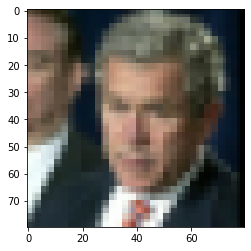

reduced pixel image


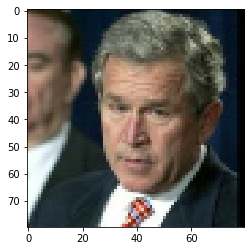

In [20]:
img = next(iter(X_trainDS.take(1)))
print('original image')
plt.imshow(img[0].numpy()[0])
plt.show()
print('reduced pixel image')
plt.imshow(img[1].numpy()[0])
plt.show()

In [0]:
def train():
  start = time.time()
  lossfn = keras.losses.MeanSquaredError()
  accuracy = metrics.Accuracy()
  accuracy.reset_states()
  val_accuracy = metrics.Accuracy()
  val_accuracy.reset_states()
  optimizer = optimizers.Adam(learning_rate=0.003)
  model = AutoEncoder()
  epochs =50

  for epoch in range(epochs):
    for step, (x,y) in enumerate(X_trainDS):
      with tf.GradientTape() as tape:
        logits = model(x)
        loss = lossfn(y, logits)
        accuracy.update_state(y,logits)

      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      val_data = next(iter(X_valDS))
      val_accuracy.update_state( val_data[1] , model(val_data[0]))
      del val_data
      gc.collect()
      if step%1000 ==0:
        print(f'train loss after step {step} is {loss.numpy()}')
        print(f'train accuracy after step {step} is {accuracy.result()}')
        accuracy.reset_states()
        print(f'validation accuracy after step {step} is {val_accuracy.result()}')
        val_accuracy.reset_states()

    print(f'Accuracy after epoch {epoch} is {accuracy.result()}')
    accuracy.reset_states()
  end = time.time()
  print(f'total time take in training is {(end-start)/60} minutes')
  predictions =[]
  real =[]
  for step, (x,y) in enumerate(X_valDS):
    prediction = model(x)
    predictions.append(prediction.numpy())
    real.append(y.numpy())
  return predictions, real, model


In [44]:
pred, real, model = train()

train loss after step 0 is 0.22670890390872955
train accuracy after step 0 is 0.00014160155842546374
validation accuracy after step 0 is 0.00025390624068677425
Accuracy after epoch 0 is 0.00011341544450260699
train loss after step 0 is 0.22298072278499603
train accuracy after step 0 is 0.0
validation accuracy after step 0 is 0.00017462836694903672
Accuracy after epoch 1 is 0.00012795960356015712
train loss after step 0 is 0.2080763578414917
train accuracy after step 0 is 0.0
validation accuracy after step 0 is 0.00010843912605196238
Accuracy after epoch 2 is 0.00019328139023855329
train loss after step 0 is 0.2268385887145996
train accuracy after step 0 is 4.394531424622983e-05
validation accuracy after step 0 is 0.0001646084274398163
Accuracy after epoch 3 is 0.00010989728616550565
train loss after step 0 is 0.2182036191225052
train accuracy after step 0 is 0.0
validation accuracy after step 0 is 0.00016216702351812273
Accuracy after epoch 4 is 0.00012050617806380615
train loss after 

In [46]:
pred[0][0].shape

(80, 80, 3)

In [47]:
real[0][0].shape

(80, 80, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


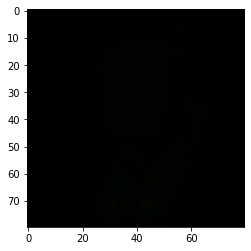

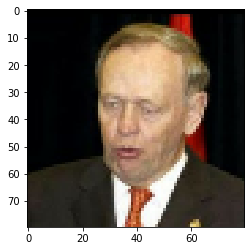

In [59]:
plt.imshow(((pred[0][0]*255).astype('int64')))
plt.show()
plt.imshow(real[0][0])
plt.show()